<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Яблочников Вяччеслав Сергеевич

**Забавный факт о себе:**

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
import gdown

url = "https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

Access denied with the following error:



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1P1wKk9L_qygClAAPoEs5BCUUQZnSrgWK 



В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [4]:
df_ria = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/iad/dl_iad/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [5]:
df_vk = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/iad/dl_iad/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [6]:
df_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/iad/dl_iad/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-6-5faf0586307c>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/iad/dl_iad/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [7]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [8]:
target_tags = {tag for tag, cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [9]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item, jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [10]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [11]:
df_ria

,href,date,time,title,snippet,text,category,tags,shows,target_tags
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"биньямин нетаньяху,израиль,в мире",728.0,"[668, 583, 38]"
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"эммануэль макрон,франция,в мире",3086.0,"[370, 1178, 38]"
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,теннис,79.0,[712]
5,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"кевин спейси,сша,в мире",2058.0,"[594, 38]"
6,/20181231/1548961194.html,2018-12-31,"31 декабря 2018, 23:06","""Зимняя классика"" НХЛ в 2020 году пройдет в Да...","""Зимняя классика"" - матч регулярного чемпионат...","МОСКВА, 31 дек - РИА Новости. ""Зимняя классика...",NaN,"нхл,хоккей",89.0,"[1292, 867]"
...,...,...,...,...,...,...,...,...,...,...
201792,/20180315/1517454702.html,2018-03-15,"15 марта 2018, 14:48","""Газпром"" выделит 22,5 млрд рублей на газопров...","<p><strong>МОСКВА, 15 мар — РИА Новости.</str...","МОСКВА, 15 мар — РИА Новости. Председатель пра...",Экономика,"газпром,вологодская область,экономика",12.0,"[676, 587, 359]"
201793,/20180315/1516435453.html,2018-03-15,"15 марта 2018, 14:48","Столтенберг проведет встречу с Джонсоном по ""д...","<p><strong>БРЮССЕЛЬ, 15 мар — РИА Новости.</s...","БРЮССЕЛЬ, 15 мар — РИА Новости. НАТО готова ок...",В мире,"дело об отравлении скрипалей,нато,великобритан...",584.0,"[662, 1076, 439, 38]"
201794,/20180315/1516435219.html,2018-03-15,"15 марта 2018, 14:47","Строившийся 10 лет ТЦ ""Лухмановский"" в Москве ...",В московском районе Кожухово сдали в эксплуата...,"МОСКВА, 15 мар — РИА Недвижимость. В московско...",Недвижимость,"долгострой,коммерческая недвижимость,москва,ро...",589.0,"[1395, 597, 319, 1075, 95, 1220]"
201795,/20180315/1516435313.html,2018-03-15,"15 марта 2018, 14:47",Британские военные смогут поставить прививку о...,"<p><strong></strong></p>\n<p><strong>ЛОНДОН, ...","\nЛОНДОН, 15 мар — РИА Новости, Мария Табак. Б...",В мире,"великобритания,в мире",471.0,"[439, 38]"


In [12]:
df_ria.target_tags.values[:3]

array([list([668, 583, 38]), list([370, 1178, 38]), list([712])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [13]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    if pd.isnull(text):
        return "#UNKN"

    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [15]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [16]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [17]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [18]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [19]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [20]:
# your code here
# ヽ(♡‿♡)ノ

df_vk['title_clean'] = df_vk.title.apply(normalise_text)
df_ria['snippet_clean'] = df_ria.snippet.apply(normalise_text)
df_vk['snippet_clean'] = df_vk.snippet.apply(normalise_text)


## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [21]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [22]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [23]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [24]:
mask = df.date.apply(lambda w: pd.to_datetime(w).month_name())

In [25]:
mask.unique()

array(['December', 'November', 'October', 'September', 'August', 'July',
       'June', 'May', 'April', 'March'], dtype=object)

In [26]:
# your code here
# ♡ (´｡• ω •｡`)

df_test = df[mask == 'December']
df_val = df[mask.isin(['October', 'November'])]
df_train = df[~mask.isin(['December', 'November', 'October'])]

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [27]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1089, 588]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[728, 38]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[458, 394]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1209]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1347, 38]"


Напишем датасет для поставки данных в нейросеть.


In [28]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

       if snippet is not None:
            self.X_snippet = self.create_text(snippet, max_snippet_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        if max_len is None:
            return

        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if hasattr(self, 'X_snippet'):
            return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])

        return (self.X_title[idx, :], self.y[idx])

__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [29]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# Внесите в код датасета выше свои правки

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [30]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [31]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [33]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [32]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [33]:
!pip3 install -q pytorch_lightning

In [33]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title, snippet=None):
        if snippet is not None:
            result = self.model(title, snippet)
        else:
            result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        *title_snippet, target = train_batch
        logits = self.model(*title_snippet)

        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        wandb.log({"train_loss": loss})
        return loss

    def validation_step(self, val_batch, batch_idx):
        *title_snippet, target = val_batch
        logits = self.model(*title_snippet)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        wandb.log({"val_loss": loss})

        return loss

Обучим модель.

In [ ]:
import wandb


EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "SimpleClassifier",
    "epochs": EPOCHS,
    }
)

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(accelerator="cpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

wandb: Currently logged in as: slavawertlon (slava_). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


<iframe src="https://wandb.ai/slava_/my-awesome-project?workspace=user-slavawertlon" style="border:none;height:1024px;width:100%">

https://api.wandb.ai/links/slava_/u89uoh6n

https://wandb.ai/slava_/my-awesome-project/reports/val_loss-23-12-09-22-42-30---Vmlldzo2MjE3MjI5

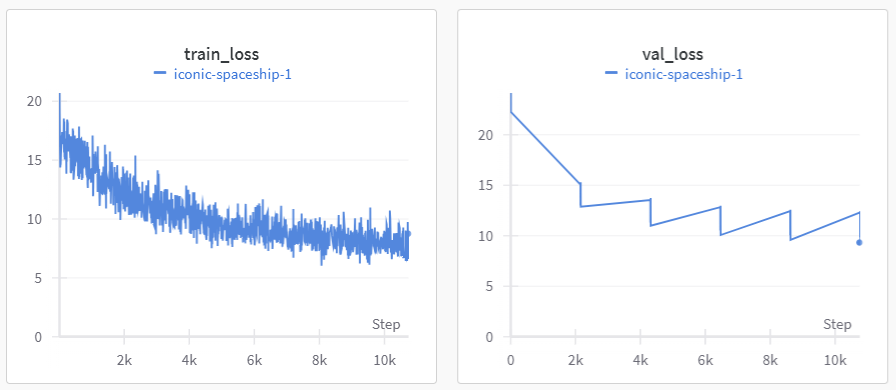

__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [38]:
class DualInputClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super(DualInputClassifier, self).__init__()
        self.embedding_title = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_snippet = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet):
        embedded_title = self.embedding_title(title)
        embedded_snippet = self.embedding_snippet(snippet)

        avg_title = embedded_title.mean(dim=1)
        avg_snippet = embedded_snippet.mean(dim=1)

        concatenated = torch.cat([avg_title, avg_snippet], dim=1)
        return self.fc(concatenated)

In [34]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset_s = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, MAX_TITLE_LEN )
val_dataset_s = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_val.snippet_clean.values, MAX_TITLE_LEN )
test_dataset_s = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_test.snippet_clean.values, MAX_TITLE_LEN )

In [35]:
train_dataloader_s = DataLoader(train_dataset_s, shuffle=True, batch_size=64, num_workers=4)
val_dataloader_s = DataLoader(val_dataset_s, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model = DualInputClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project_2",

    # track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "DualInputClassifier",
    "epochs": EPOCHS,
    }
)

train_module = TrainLightningModule(model, LR, criterion)

trainer = pl.Trainer(accelerator="cpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader_s, val_dataloader_s)

train_loss,▇█▇▆▆▄▆▅▅▅▄▄▂▄▄▃▃▂▃▃▃▂▂▂▂▂▃▂▂▂▁▂▂▃▁▂▁▂▂▂
val_loss,█▇▄▃▃▃▃▃▃▃▂▂▂▂▃▂▂▃▂▂▂▂▃▂▁▂▂▂▂▂▂▁▁▁▂▁▂▂▂▁
train_loss,7.90147
val_loss,9.32857


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                | Params
--------------------------------------------------
0 | model     | DualInputClassifier | 7.0 M 
1 | criterion | CrossEntropyLoss    | 0     
--------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


https://api.wandb.ai/links/slava_/20ndfo2p

https://api.wandb.ai/links/slava_/7uw1lvp5

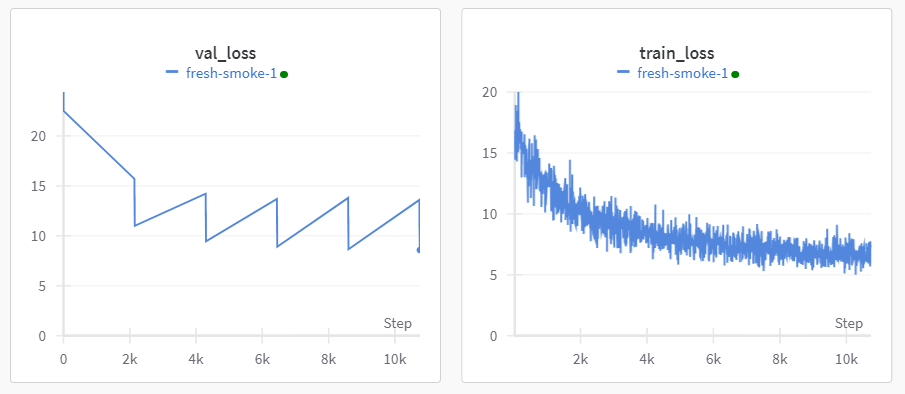

судя по графику лосса результат и правда лучше

In [ ]:
# your code here
# (￢_￢)

In [ ]:
torch.save(model_baseline.state_dict(), 'model_baseline.pt')
torch.save(model.state_dict(), 'model.pt')

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [36]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [39]:
EMBEDDING_DIM = 300


model = DualInputClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/iad/dl_iad/model.pt'))


model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
model_baseline.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/iad/dl_iad/model_baseline.pt'))

<All keys matched successfully>

In [40]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [41]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9930227398872375
Precision: 0.0004549300647340715
Recall: 0.0018533427501097322


In [42]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9963663816452026
Precision: 0.0002486441226210445
Recall: 0.00028215846396051347


In [43]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983107447624207
Precision: 0.0
Recall: 0.0


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [44]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    for title, target in dataloader:
        logit = model(title)
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ будем максиммизировать f1-score, так как именно она позволяет получить все хорошее от максимизации precision и recall

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [45]:
# your code here
# (＠_＠)

In [46]:
test_dataloader_s = DataLoader(test_dataset_s, shuffle=False, batch_size=test_dataset.__len__())

In [47]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def find_optimal_threshold(model, val_loader, criterion):
    # Evaluate model on the validation set
    model = model.to(device)
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for val_batch in tqdm(val_loader, desc='Evaluating'):
            *title_snippet, target = val_batch

            for i in range(len(title_snippet)):
                title_snippet[i] = title_snippet[i].to(device)

            logits = model(*title_snippet)
            predictions = torch.sigmoid(logits)

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(target.cpu().numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Find the optimal threshold
    thresholds = np.linspace(0, 1, 25)
    best_f1_score = 0
    optimal_threshold = 0

    for threshold in tqdm(thresholds, desc='Finding optimal threshold'):
        binary_predictions = (all_predictions > threshold)
        f1 = f1_score(all_targets, binary_predictions, average='micro')

        if f1 > best_f1_score:
            best_f1_score = f1
            optimal_threshold = threshold

    return optimal_threshold


In [48]:
def evaluate_model(model, test_loader, threshold, criterion, ans=False):
    # Evaluate model on the test set
    model = model.to(device)
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for test_batch in tqdm(test_loader, desc='Evaluating'):
            *title_snippet, target = test_batch
            for i in range(len(title_snippet)):
                title_snippet[i] = title_snippet[i].to(device)

            logits = model(*title_snippet)
            predictions = torch.sigmoid(logits)

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(target.cpu().numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Apply the threshold
    binary_predictions = (all_predictions > threshold)

    # Calculate metrics
    precision = precision_score(all_targets, binary_predictions, average='micro')
    recall = recall_score(all_targets, binary_predictions, average='micro')
    f1 = f1_score(all_targets, binary_predictions, average='micro')

    if ans:
        return precision, recall, f1, binary_predictions
    return precision, recall, f1

In [48]:
# Train your models
criterion = torch.nn.CrossEntropyLoss()

# Find the optimal threshold on the validation set
optimal_threshold_with_snippet = find_optimal_threshold(model, val_dataloader_s, criterion)
optimal_threshold_no_snippet = find_optimal_threshold(model_baseline, val_dataloader, criterion)

# Evaluate models on the test set with the optimal threshold
precision_with_snippet, recall_with_snippet, f1_with_snippet = evaluate_model(model, test_dataloader_s, optimal_threshold_with_snippet, criterion)
precision_no_snippet, recall_no_snippet, f1_no_snippet = evaluate_model(model_baseline, test_dataloader, optimal_threshold_no_snippet, criterion)

print("Model with snippet - F1 Score:", f1_with_snippet)
print("Model without snippet - F1 Score:", f1_no_snippet)

# Compare the models and choose the better one based on your evaluation metric
if f1_with_snippet > f1_no_snippet:
    print("Model with snippet is better.")
else:
    print("Model without snippet is better.")

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Finding optimal threshold:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Finding optimal threshold:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Model with snippet - F1 Score: 0.004327910333309016
Model without snippet - F1 Score: 0.0029549935661499806
Model with snippet is better.


In [50]:
print(f'{optimal_threshold_with_snippet=}, {optimal_threshold_no_snippet=}')

optimal_threshold_with_snippet=0.5416666666666666, optimal_threshold_no_snippet=0.5416666666666666


In [51]:
print(f'{precision_with_snippet=}, {recall_with_snippet=}, {f1_with_snippet=}')

precision_with_snippet=0.0021909218682344116, recall_with_snippet=0.17581151637897396, f1_with_snippet=0.004327910333309016


In [52]:
print(f'{precision_no_snippet=}, {recall_no_snippet=}, {f1_no_snippet=}')

precision_no_snippet=0.0015003120270279963, recall_no_snippet=0.0971589958936435, f1_no_snippet=0.0029549935661499806


In [49]:
import gc
gc.collect()

0

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [55]:
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[236, 75]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[17, 863]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[812, 142]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1537]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[749, 863]"


In [50]:
oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)
oob_dataloader = DataLoader(oob_dataset, shuffle=False, batch_size=oob_dataset.__len__())

In [61]:
# your code here
# (❍ᴥ❍ʋ)

# сниппетов для этой выборки нет, поэтому смотрим только на базовую модель
precision_no_snippet, recall_no_snippet, f1_no_snippet = evaluate_model(model_baseline, oob_dataloader, optimal_threshold_no_snippet, criterion)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

In [62]:
print(f'{precision_no_snippet=}, {recall_no_snippet=}, {f1_no_snippet=}')

precision_no_snippet=0.0012859457934482374, recall_no_snippet=0.06723842195540308, f1_no_snippet=0.002523626812247315


In [63]:
# прсадка качества по f1-score
0.0029549935661499806 - 0.002523626812247315

0.0004313667539026654

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# (⊙_⊙)

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
# your code here
# (⌐■_■)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]

# your code here
# (っ˘ڡ˘ς)

In [50]:
df_vk.head()

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNKN,[0]
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNKN,[0]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNKN,[0]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNKN,[0]
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNKN,[0]


In [72]:
df_vk.snippet.unique()

array([nan,
       'Ранее в соцсетях появились кадры, на которых запечатлены палаты с обшарпанными стенами и отваливающейся штукатуркой, а также кровати с грязными матрасами.\nВ подписи автор снимков сравнил такие условия с "концлагерными помещениями". В комментариях к фото бывшие пациенты отметили, что подобная ситуация в больнице не меняется на протяжении 20 лет.',
       'Новый пулемет, крупнокалиберный автомат и долгожданный сменщик пистолета Макарова — в концерне "Калашников" на днях сообщили об успешной реализации сразу нескольких важных проектов по стрелковому оружию. Перспективные образцы концерн намерен предложить не только российской армии, но и зарубежному рынку.',
       ...,
       '#РИА_10VK \nДрузья, рассказываем вам, какие гаджеты больше всего обсуждали пользователи ВК в этом месяце! Представляем сентябрьский список нашего спецпроекта с ВКонтакте #10VK: https://ria.ru/10vk/',
       'Двадцать восьмого сентября в Москве стартовали сразу две выставки — "Игромир" и "Comic 

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [51]:
vk_dataset = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_vk.snippet_clean.values, MAX_TITLE_LEN)

vk_dataloader = DataLoader(vk_dataset, shuffle=False, batch_size=vk_dataset.__len__())

AttributeError: ignored

In [52]:
import gc
gc.collect()

8

In [64]:
# optimal_threshold_with_snippet=0.5416666666666666
# criterion = torch.nn.CrossEntropyLoss()

In [65]:
precision_with_snippet, recall_with_snippet, f1_with_snippet, preds = evaluate_model(model, vk_dataloader, optimal_threshold_with_snippet, criterion, ans=True)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
print(f'{precision_with_snippet=}, {recall_with_snippet=}, {f1_with_snippet=}')

precision_with_snippet=1.8728289549571868e-05, recall_with_snippet=0.004415897230028101, f1_with_snippet=3.7298392651199424e-05


In [67]:
preds.shape

(19928, 1583)

In [68]:
# Ваш код с сохранением данных

# your code here
# ¯\_(ツ)_/¯

In [69]:
torch.save(preds, 'target_tags_preds.pt')

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [53]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели? **David Dale**
2. Как выглядит архитектура модели? **Как пишет автор: This is a very small distilled version of the [bert-base-multilingual-cased](https://huggingface.co/bert-base-multilingual-cased)** **Можно посмотреть [здесь](https://arxiv.org/pdf/1810.04805.pdf)**  Насколько модель большая? **Model size 29.2M params**
3. На каких данных обучена модель? **([link](https://github.com/sismetanin/sentiment-analysis-in-russian))** Адекватно ли использовать её для классификации комментариев ВК? **Да, так как модель как раз училась на коротких русских текстах**

Установим библиотеку. 🤗🤗🤗

In [ ]:
!pip3 install -q transformers

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [54]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="seara/rubert-tiny2-russian-sentiment", device=device)

In [55]:
# from here: https://huggingface.co/docs/transformers/main_classes/pipelines

pipe('ʕ•ᴥ•ʔ')

[{'label': 'positive', 'score': 0.48686233162879944}]

In [56]:
# your code here
# ʕ•ᴥ•ʔ

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
!pip install -q datasets

In [57]:
comms = df_comments.text.to_list()

In [58]:
len(comms)

2612629

In [59]:
import gc
gc.collect()

82

In [ ]:
import pandas as pd
save_interval = 100000

# Apply sentiment analysis to each comment with tqdm for progress tracking
results = []
all_results = []
for i, comment in enumerate(tqdm(comms, desc="Sentiment Analysis")):
    try:
        sentiment = pipe(comment)
    except Exception as e:
        sentiment = [{'label': 'None', 'score': None}]

    results.append({'Comment': comment, 'label': sentiment[0]['label'], 'score': sentiment[0]['score']})
    all_results.append({'Comment': comment, 'label': sentiment[0]['label'], 'score': sentiment[0]['score']})

    # Save results to a CSV file every save_interval comments
    if (i + 1) % save_interval == 0:
        df_partial = pd.DataFrame(results)
        df_partial.to_csv(f'/content/drive/MyDrive/Colab Notebooks/iad/dl_iad/datasets/results_partial_{i + 1}.csv', index=False)
        results = []  # Reset the results list
        gc.collect()

# Save the final results to a CSV file
all_df_final = pd.DataFrame(all_results)
df_final = pd.DataFrame(results)

df_final.to_csv('/content/drive/MyDrive/Colab Notebooks/iad/dl_iad/datasets/results_final.csv', index=False)
all_df_final.to_csv('/content/drive/MyDrive/Colab Notebooks/iad/dl_iad/datasets/all_results_final.csv', index=False)

Sentiment Analysis:   0%|          | 0/2612629 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentiall

...

In [ ]:
all_df_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/iad/dl_iad/datasets/all_results_final.csv')

In [ ]:
df_vk['sentiment_verdict'] = all_df_final['label']
df_vk['sentiment_score'] = all_df_final['score']

# <ваш код для сохранения данных>

# your code here
# ¯\_(ツ)_/¯

# P.S. Код для скоринга комментариев работает довольно долго. Первый, кто проскорит всю базу, может поделиться ей в общем чате с однокурсниками
# Если вы используете эту базу, просто продемонстрируйте при решении этого пункта, что ваш код работает

## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [ ]:
# your code here
# ʕ•ᴥ•ʔ

df_vk['sentiment_verdict'].value_counts() / len(df_vk['sentiment_verdict'])

In [ ]:
df_vk[df_vk['sentiment_verdict'] == 'positive'].sort_values('sentiment_score', ascending=False).head(10)

In [ ]:
import time
from google.colab import output

df_vk[df_vk['sentiment_verdict'] == 'negative'].sort_values('sentiment_score', ascending=False).head(10)

time.sleep(10)

output.clear()

__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [ ]:
# your code here
# [✖‿✖]

df_g = df_comments.groub_by('post_id')['sentiment_verdict'].agg(lambda x: x.value_counts())
df_g

In [ ]:
df_vk['pos_num_comm'] = df_g[]

__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [ ]:
# your code here
# ┌(ಠ_ಠ)┘

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [ ]:
# your code here
# ฅ^•ﻌ•^ฅ

Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

In [ ]:
# your code here
# ٩(⁎❛ᴗ❛⁎)۶

__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [ ]:
# your code here
# ヾ(๑╹◡╹)ﾉ